# Working with Twelve Labs in Pixeltable

Twelve Labs provides multimodal embeddings that project text, images, audio, and video into the **same semantic space**. This enables true **cross-modal search** - the most powerful feature of this integration.

**What makes this special?** You can search a video index using *any* modality:

| Query Type | Use Case |
|------------|----------|
| **Text to Video** | "Find clips of a man giving a speech" |
| **Image to Video** | Find videos visually similar to a photo |
| **Audio to Video** | Find videos with similar speech/sounds |
| **Video to Video** | Find videos similar to a clip |

This notebook demonstrates this cross-modal capability with video, then shows how to apply the same embeddings to other modalities.

### Prerequisites

- A Twelve Labs account with an API key ([playground.twelvelabs.io](https://playground.twelvelabs.io/))
- Audio and video must be at least 4 seconds long

## Setup

In [ ]:
%pip install -qU pixeltable twelvelabs

In [2]:
import getpass
import os

if 'TWELVELABS_API_KEY' not in os.environ:
    os.environ['TWELVELABS_API_KEY'] = getpass.getpass(
        'Enter your Twelve Labs API key: '
    )

In [ ]:
import pixeltable as pxt
import pixeltable.functions as pxtf

# Create a fresh directory for our demo
pxt.drop_dir('twelvelabs_demo', force=True)
pxt.create_dir('twelvelabs_demo')

## Cross-Modal Video Search

Let's index a video and search it using text, images, audio, and other videos - all against the same index.

### Create Video Table and Index

In [4]:
# Create a table for videos
video_t = pxt.create_table('twelvelabs_demo/videos', {'video': pxt.Video})

# Insert a sample video
video_url = 'https://github.com/pixeltable/pixeltable/raw/main/docs/resources/The-Pursuit-of-Happiness.mp4'
video_t.insert([{'video': video_url}])

Created table 'videos'.
Inserted 1 row with 0 errors in 1.22 s (0.82 rows/s)


1 row inserted.

In [5]:
# Create a view that segments the video into searchable chunks
# Twelve Labs requires minimum 4 second segments
video_chunks = pxt.create_view(
    'twelvelabs_demo/video_chunks',
    video_t,
    iterator=pxtf.video.video_splitter(
        video=video_t.video, duration=5.0, min_segment_duration=4.0
    ),
)

# Add embedding index for cross-modal search
video_chunks.add_embedding_index(
    'video_segment', embedding=pxtf.twelvelabs.embed.using(model_name='marengo3.0')
)

Let's look at the index we just added in the table metadata:

In [6]:
video_chunks

view 'twelvelabs_demo/video_chunks' (of 'twelvelabs_demo/videos')

        Column Name             Type Computed With
                pos    Required[Int]              
      segment_start            Float              
  segment_start_pts              Int              
        segment_end            Float              
    segment_end_pts              Int              
      video_segment  Required[Video]              
              video            Video              

 Index Name         Column  Metric                                          Embedding
       idx0  video_segment  cosine  embed(video_segment, model_name='marengo3.0', ...

The iterator created a larger table from our single video:

In [7]:
video_chunks.count()

51

### Text to Video Search

Find video segments matching a text description.

video_segment,score
,0.416
,0.31
,0.251

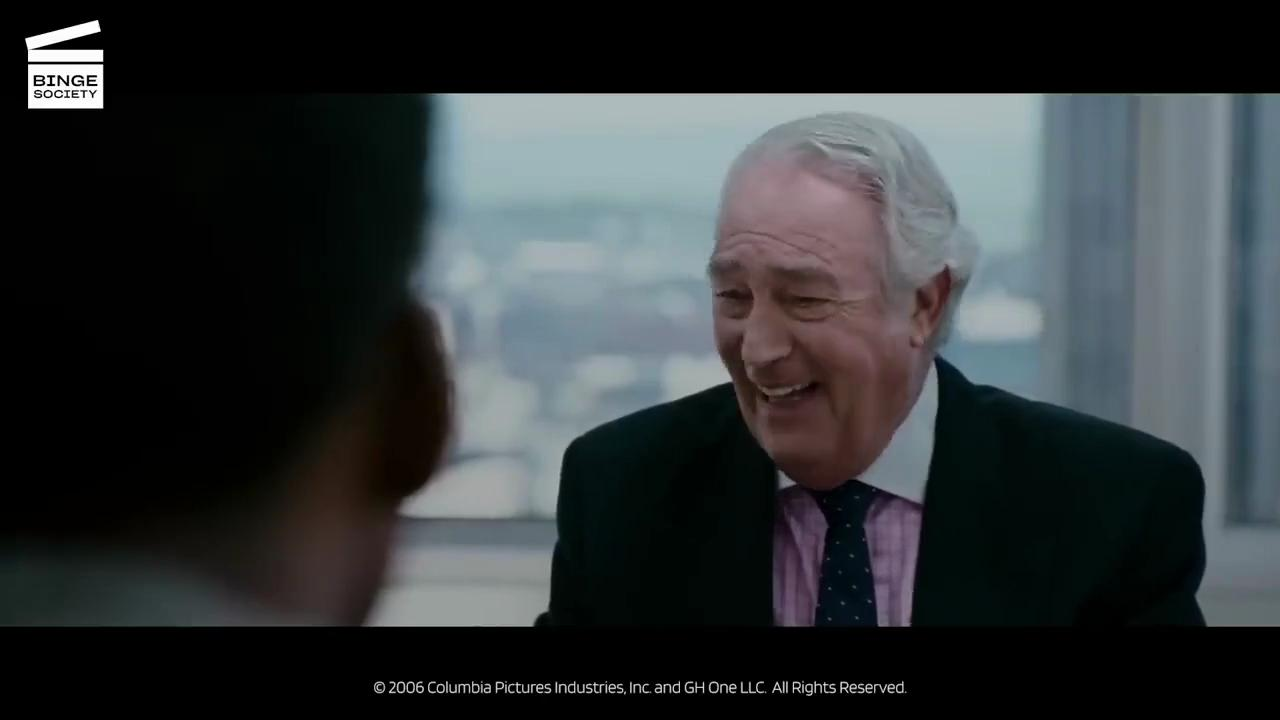
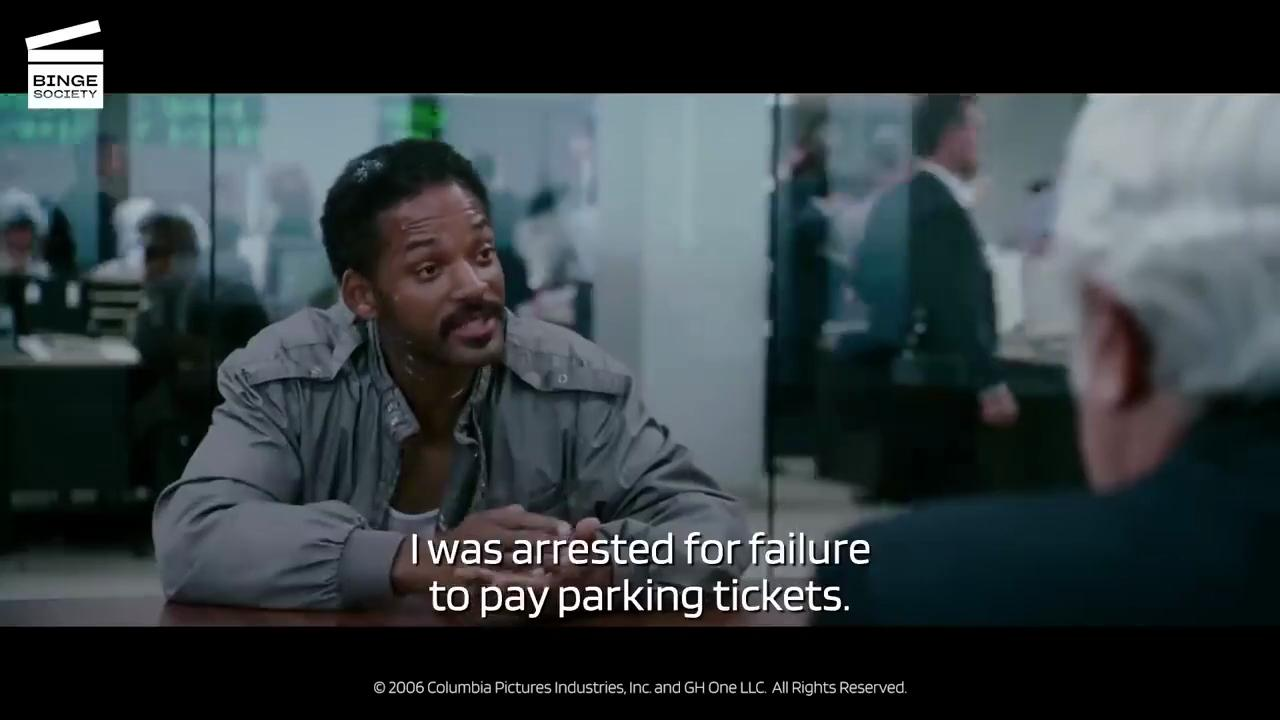
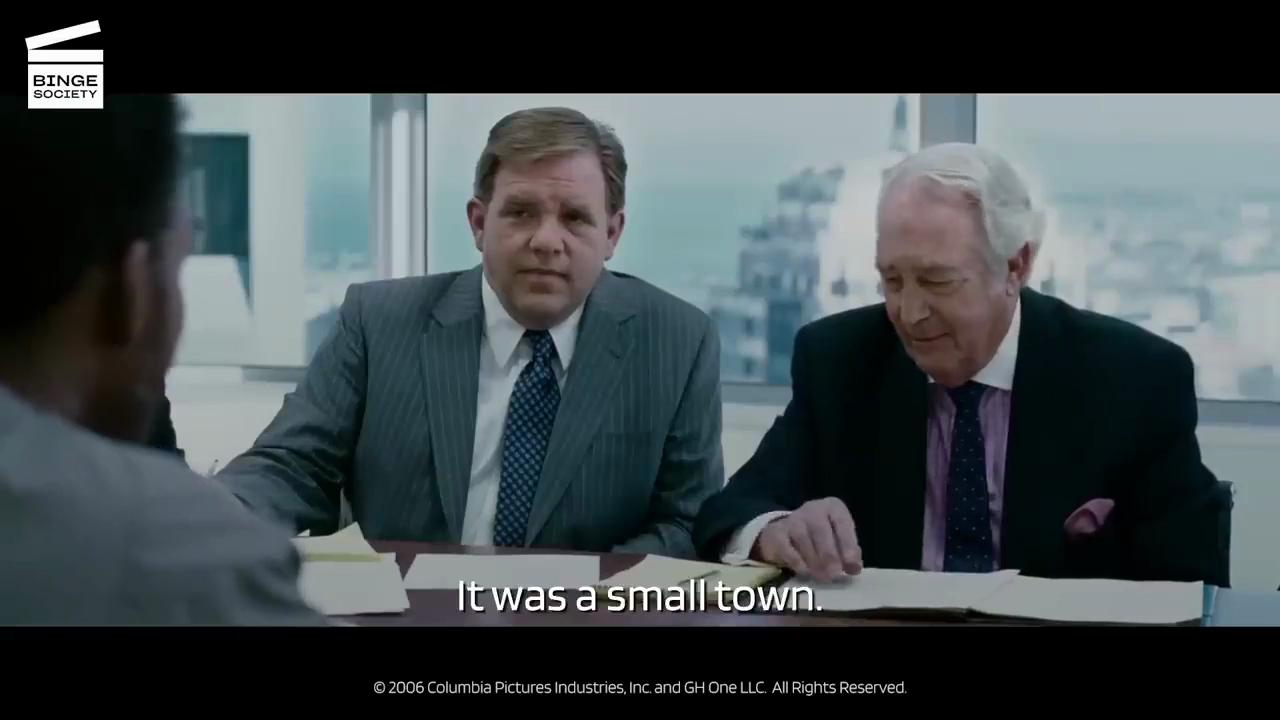

In [12]:
sim = video_chunks.video_segment.similarity(string='pink')

video_chunks.order_by(sim, asc=False).limit(3).select(
    video_chunks.video_segment, 
    score=sim
).collect()

### Image to Video Search

Find video segments similar to an image.

video_segment,score
,0.724
,0.18

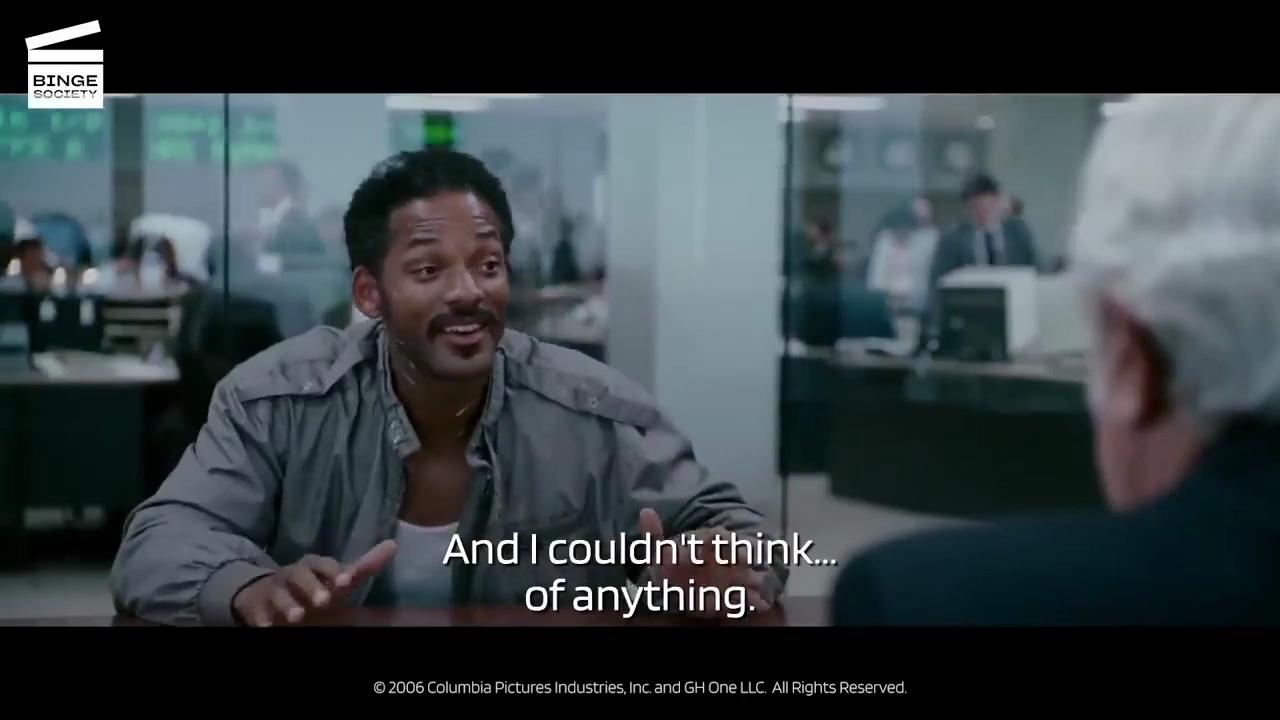
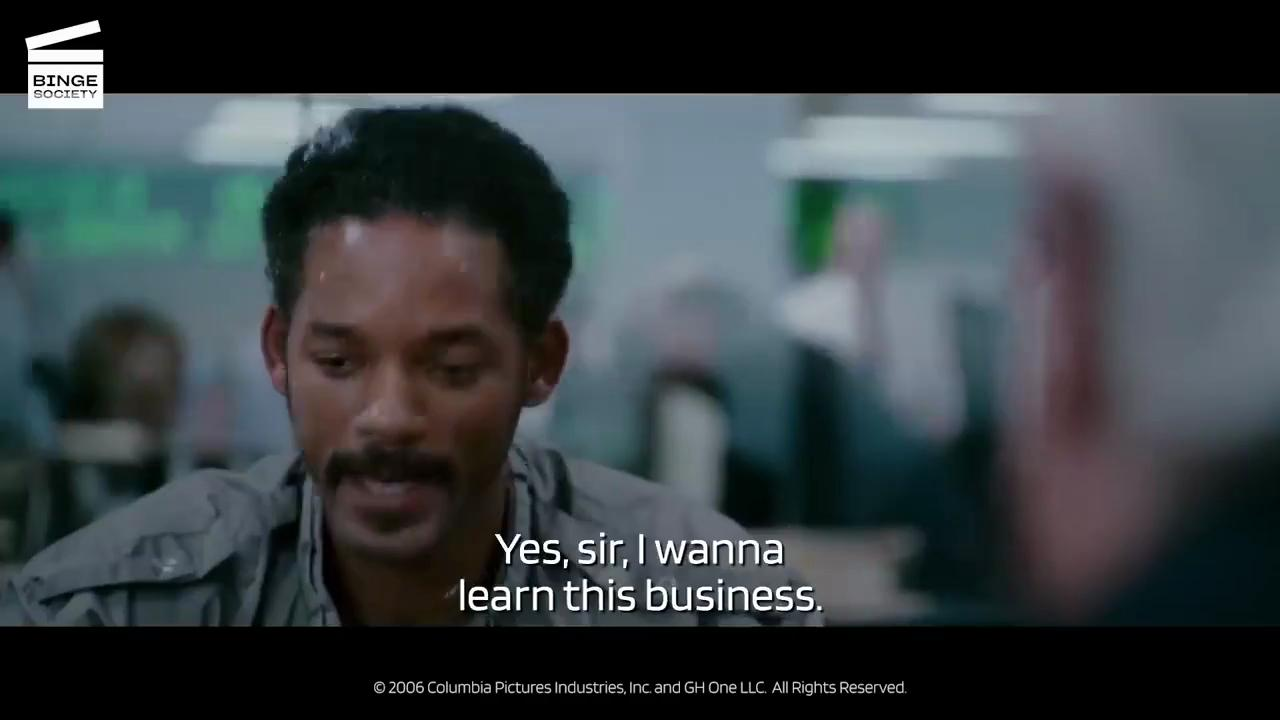

In [11]:
image_query = 'https://github.com/pixeltable/pixeltable/raw/main/docs/resources/The-Pursuit-of-Happiness-Screenshot.png'

sim = video_chunks.video_segment.similarity(image=image_query)

video_chunks.order_by(sim, asc=False).limit(2).select(
    video_chunks.video_segment, score=sim
).collect()

### Video to Video Search

Find video segments similar to another video clip.

video_segment,score
,0.653
,0.612

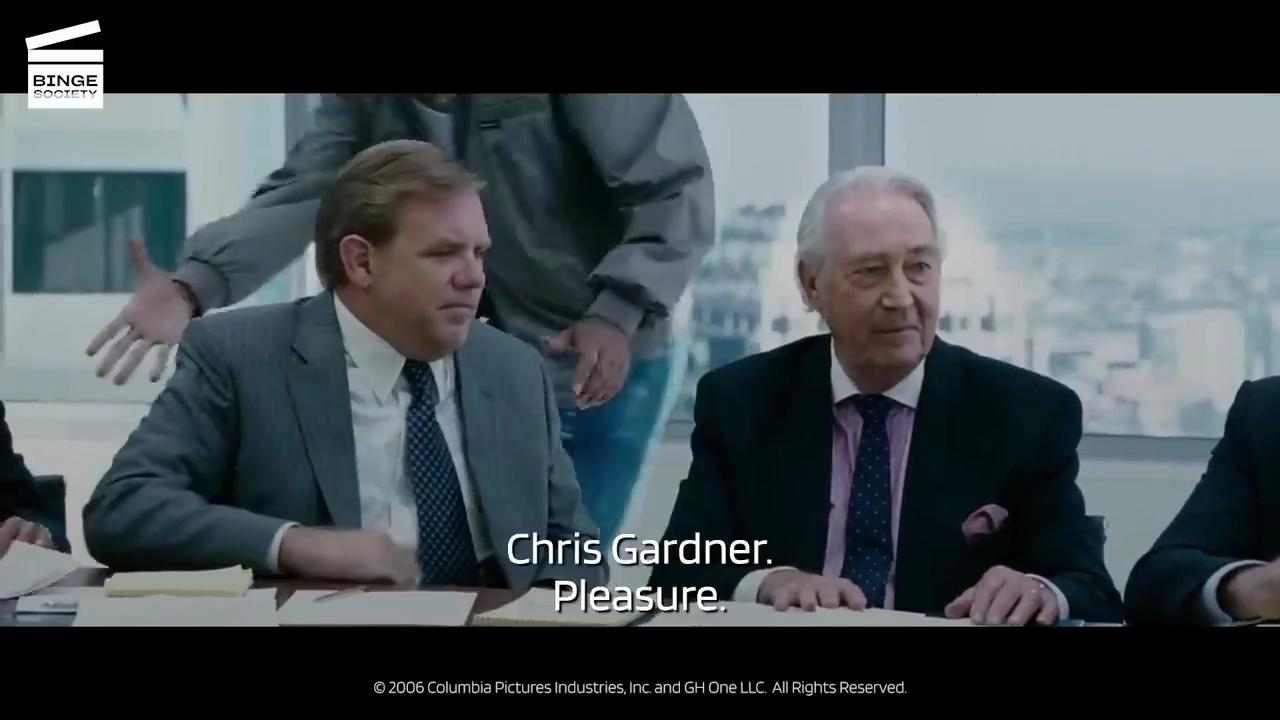
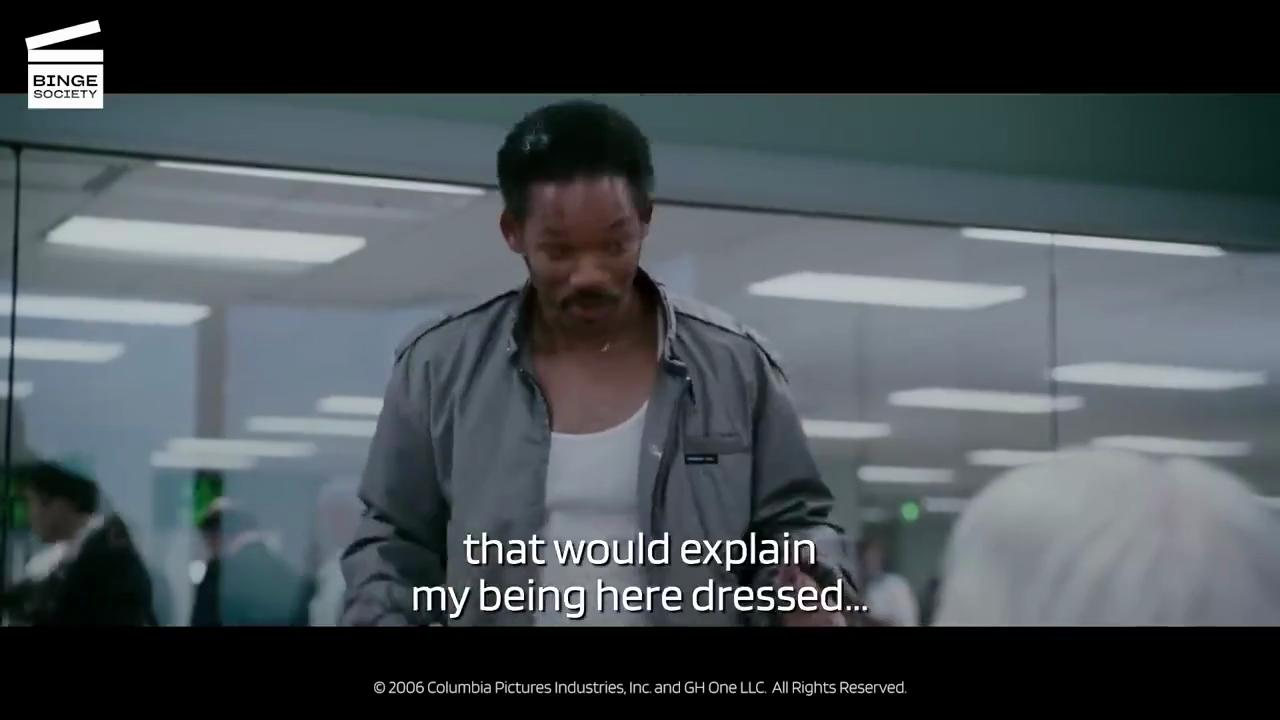

In [13]:
video_query = 'https://github.com/pixeltable/pixeltable/raw/main/docs/resources/The-Pursuit-of-Happiness-Video-Extract.mp4'

sim = video_chunks.video_segment.similarity(video=video_query)

video_chunks.order_by(sim, asc=False).limit(2).select(
    video_chunks.video_segment, score=sim
).collect()

### Audio to Video Search

Find video segments with similar audio/speech content.

video_segment,score
,0.036
,0.017

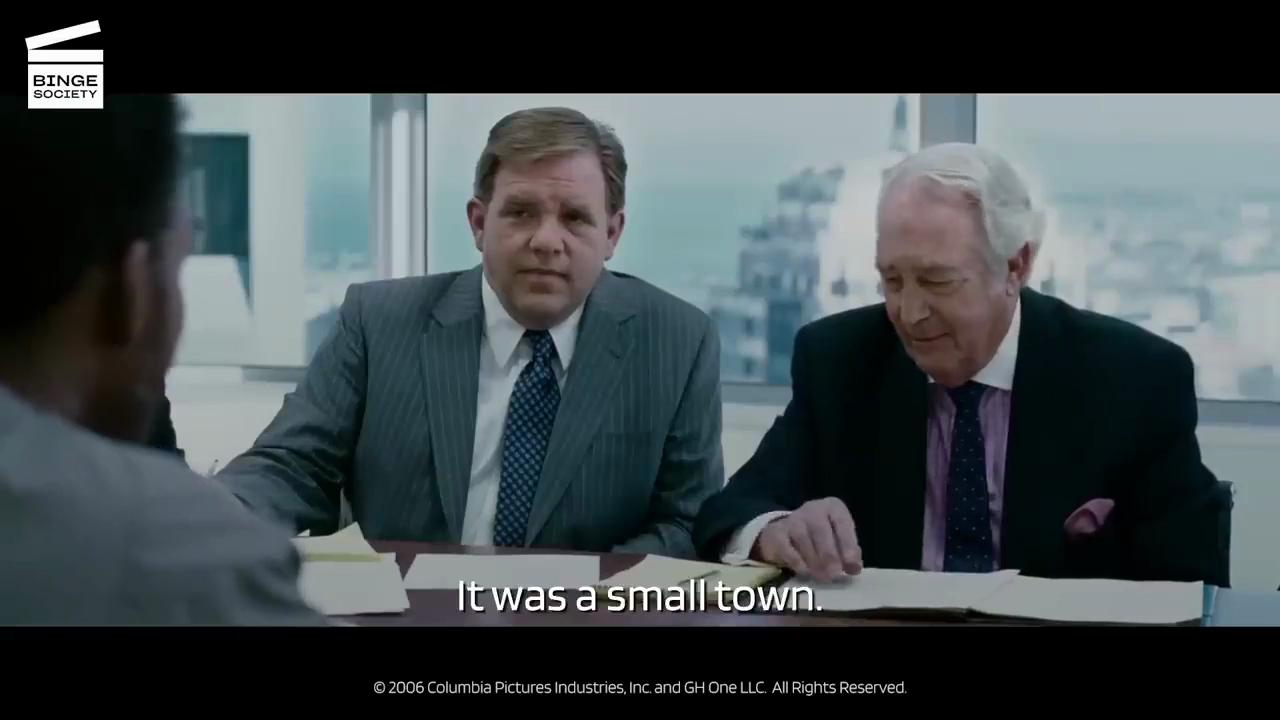
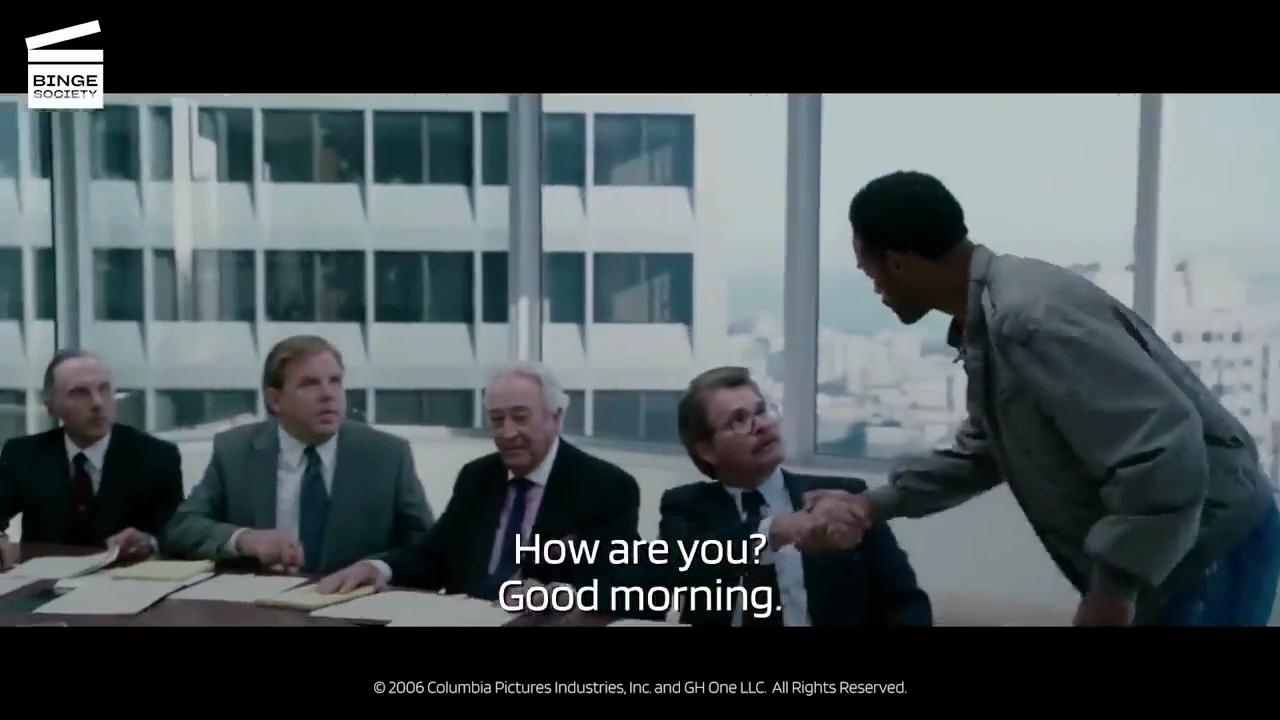

In [14]:
audio_query = 'https://github.com/pixeltable/pixeltable/raw/main/docs/resources/The-Pursuit-of-Happiness-Audio-Extract.m4a'

sim = video_chunks.video_segment.similarity(audio=audio_query)

video_chunks.order_by(sim, asc=False).limit(2).select(
    video_chunks.video_segment, score=sim
).collect()

## Embedding Options

For video embeddings, you can focus on specific aspects:

- `'visual'` - Focus on what you see
- `'audio'` - Focus on what you hear
- `'transcription'` - Focus on what is said

In [17]:
# Add a visual-only embedding column
video_chunks.add_computed_column(
    visual_embedding=pxtf.twelvelabs.embed(
        video_chunks.video_segment,
        model_name='marengo3.0',
        embedding_option=['visual'],
    )
)

video_chunks.select(
    video_chunks.video_segment, video_chunks.visual_embedding
).limit(2).collect()

Error: Error while evaluating computed column 'visual_embedding':
headers: {'date': 'Mon, 02 Feb 2026 21:11:20 GMT', 'content-type': 'application/json; charset=UTF-8', 'content-length': '139', 'connection': 'keep-alive', 'tl-report': 'backend', 'vary': 'Accept-Encoding', 'x-ratelimit-dimensions': 'Request', 'x-ratelimit-request-limit': '50', 'x-ratelimit-request-remaining': '0', 'x-ratelimit-request-reset': '1770152274', 'x-trace-id': '1143691492141690475'}, status_code: 429, body: {'code': 'too_many_requests', 'message': 'You have exceeded the rate limit (50req/1day). Please try again later after 2026-02-03T20:57:54Z.'}

## Other Modalities: Text, Images, and Documents

Twelve Labs embeddings also work for text, images, and documents. Here's a compact example showing **multiple embedding indexes on a single table**.

In [16]:
# Create a multimodal content table
content_t = pxt.create_table(
    'twelvelabs_demo/content',
    {
        'title': pxt.String,
        'description': pxt.String,
        'thumbnail': pxt.Image,
    },
)

# Add computed column combining title and description
content_t.add_computed_column(
    text_content=content_t.title + '. ' + content_t.description
)

# Add embedding index on combined text column
content_t.add_embedding_index(
    'text_content', embedding=pxtf.twelvelabs.embed.using(model_name='marengo3.0')
)

# Add embedding index on image column
content_t.add_embedding_index(
    'thumbnail', embedding=pxtf.twelvelabs.embed.using(model_name='marengo3.0')
)

Created table 'content'.
Added 0 column values with 0 errors in 0.01 s


In [22]:
# Insert sample content
content_t.insert(
    [
        {
            'title': 'Beach Sunset',
            'description': 'A beautiful sunset over the ocean with palm trees.',
            'thumbnail': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000025.jpg',
        },
        {
            'title': 'Mountain Hiking',
            'description': 'Hikers climbing a steep mountain trail with scenic views.',
            'thumbnail': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000139.jpg',
        },
        {
            'title': 'City Street',
            'description': 'Busy urban street with cars and pedestrians.',
            'thumbnail': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000042.jpg',
        },
        {
            'title': 'Wildlife Safari',
            'description': 'Elephants and zebras on the African savanna.',
            'thumbnail': 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000061.jpg',
        },
    ]
)

Inserted 4 rows with 0 errors in 1.45 s (2.75 rows/s)


4 rows inserted.

We can see the two indexes we added in the schema:

In [23]:
content_t

table 'twelvelabs_demo/content'

   Column Name    Type                 Computed With
         title  String                              
   description  String                              
     thumbnail   Image                              
  text_content  String  (title + '. ') + description

 Index Name        Column  Metric                                          Embedding
       idx4  text_content  cosine  embed(text_content, None, model_name='marengo3...
       idx5     thumbnail  cosine          embed(thumbnail, model_name='marengo3.0')

In [24]:
# Search by text description
sim = content_t.text_content.similarity(string='outdoor nature adventure')

content_t.order_by(sim, asc=False).limit(2).select(
    content_t.title, content_t.text_content, score=sim
).collect()

Error: In row 0 the expression embed('outdoor nature adventure', None, model_name='marengo3.0') encountered exception TooManyRequestsError:
headers: {'date': 'Mon, 02 Feb 2026 21:29:08 GMT', 'content-type': 'application/json; charset=UTF-8', 'content-length': '141', 'connection': 'keep-alive', 'tl-report': 'backend', 'vary': 'Accept-Encoding', 'x-ratelimit-dimensions': 'Request', 'x-ratelimit-request-limit': '8', 'x-ratelimit-request-remaining': '0', 'x-ratelimit-request-reset': '1770067796', 'x-trace-id': '6626304456912760506'}, status_code: 429, body: {'code': 'too_many_requests', 'message': 'You have exceeded the rate limit (8req/1minute). Please try again later after 2026-02-02T21:29:56Z.'}
with ''outdoor nature adventure'' = 'outdoor nature adventure', 'None' = None, ''marengo3.0'' = 'marengo3.0'
Stack:
  File "/Users/alison-pxt/Documents/Github/pixeltable/.venv/lib/python3.13/site-packages/twelvelabs/embed/v_2/raw_client.py", line 304, in create
    raise TooManyRequestsError(
    ...<8 lines>...
    )

  File "/Users/alison-pxt/Documents/Github/pixeltable/.venv/lib/python3.13/site-packages/twelvelabs/embed/v_2/client.py", line 246, in create
    _response = await self._raw_client.create(
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<8 lines>...
    )
    ^

  File "/Users/alison-pxt/Documents/Github/pixeltable/.venv/lib/python3.13/site-packages/pixeltable/functions/twelvelabs.py", line 77, in embed
    res = await cl.embed.v_2.create(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^
        input_type='text', model_name=model_name, text=twelvelabs.TextInputRequest(input_text=text)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^

  File "/Users/alison-pxt/miniconda3/lib/python3.13/asyncio/tasks.py", line 304, in __step_run_and_handle_result
    result = coro.send(None)

  File "/Users/alison-pxt/miniconda3/lib/python3.13/asyncio/futures.py", line 199, in result
    raise self._exception.with_traceback(self._exception_tb)

  File "/Users/alison-pxt/Documents/Github/pixeltable/.venv/lib/python3.13/site-packages/nest_asyncio.py", line 98, in run_until_complete
    return f.result()
           ~~~~~~~~^^

  File "/Users/alison-pxt/Documents/Github/pixeltable/.venv/lib/python3.13/site-packages/pixeltable/utils/coroutine.py", line 21, in run_coroutine_synchronously
    return loop.run_until_complete(coroutine)
           ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^

  File "/Users/alison-pxt/Documents/Github/pixeltable/.venv/lib/python3.13/site-packages/pixeltable/func/callable_function.py", line 104, in exec
    return run_coroutine_synchronously(self.py_fn(*args, **kwargs))


In [25]:
# Search by image similarity
query_image = 'https://raw.githubusercontent.com/pixeltable/pixeltable/main/docs/resources/images/000000000001.jpg'

sim = content_t.thumbnail.similarity(image=query_image)

content_t.order_by(sim, asc=False).limit(2).select(
    content_t.title, content_t.thumbnail, score=sim
).collect()

Error: In row 0 the expression embed(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x3245A9450>, model_name='marengo3.0') encountered exception TooManyRequestsError:
headers: {'date': 'Mon, 02 Feb 2026 21:29:12 GMT', 'content-type': 'application/json; charset=UTF-8', 'content-length': '141', 'connection': 'keep-alive', 'tl-report': 'backend', 'vary': 'Accept-Encoding', 'x-ratelimit-dimensions': 'Request', 'x-ratelimit-request-limit': '8', 'x-ratelimit-request-remaining': '0', 'x-ratelimit-request-reset': '1770067793', 'x-trace-id': '3340459325201321519'}, status_code: 429, body: {'code': 'too_many_requests', 'message': 'You have exceeded the rate limit (8req/1minute). Please try again later after 2026-02-02T21:29:53Z.'}
with '<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x3245A9450>' = <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x480 at 0x3245A9450>, ''marengo3.0'' = 'marengo3.0'
Stack:
  File "/Users/alison-pxt/Documents/Github/pixeltable/.venv/lib/python3.13/site-packages/twelvelabs/embed/v_2/raw_client.py", line 304, in create
    raise TooManyRequestsError(
    ...<8 lines>...
    )

  File "/Users/alison-pxt/Documents/Github/pixeltable/.venv/lib/python3.13/site-packages/twelvelabs/embed/v_2/client.py", line 246, in create
    _response = await self._raw_client.create(
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<8 lines>...
    )
    ^

  File "/Users/alison-pxt/Documents/Github/pixeltable/.venv/lib/python3.13/site-packages/pixeltable/functions/twelvelabs.py", line 102, in _
    res = await cl.embed.v_2.create(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<3 lines>...
    )
    ^

  File "/Users/alison-pxt/miniconda3/lib/python3.13/asyncio/tasks.py", line 304, in __step_run_and_handle_result
    result = coro.send(None)

  File "/Users/alison-pxt/miniconda3/lib/python3.13/asyncio/futures.py", line 199, in result
    raise self._exception.with_traceback(self._exception_tb)

  File "/Users/alison-pxt/Documents/Github/pixeltable/.venv/lib/python3.13/site-packages/nest_asyncio.py", line 98, in run_until_complete
    return f.result()
           ~~~~~~~~^^

  File "/Users/alison-pxt/Documents/Github/pixeltable/.venv/lib/python3.13/site-packages/pixeltable/utils/coroutine.py", line 21, in run_coroutine_synchronously
    return loop.run_until_complete(coroutine)
           ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^

  File "/Users/alison-pxt/Documents/Github/pixeltable/.venv/lib/python3.13/site-packages/pixeltable/func/callable_function.py", line 104, in exec
    return run_coroutine_synchronously(self.py_fn(*args, **kwargs))


In [26]:
# Cross-modal: Search images using text!
sim = content_t.thumbnail.similarity(string='shoe rack')

content_t.order_by(sim, asc=False).limit(2).select(
    content_t.title, content_t.thumbnail, score=sim
).collect()

Error: In row 0 the expression embed('shoe rack', None, model_name='marengo3.0') encountered exception TooManyRequestsError:
headers: {'date': 'Mon, 02 Feb 2026 21:29:16 GMT', 'content-type': 'application/json; charset=UTF-8', 'content-length': '141', 'connection': 'keep-alive', 'tl-report': 'backend', 'vary': 'Accept-Encoding', 'x-ratelimit-dimensions': 'Request', 'x-ratelimit-request-limit': '8', 'x-ratelimit-request-remaining': '0', 'x-ratelimit-request-reset': '1770067796', 'x-trace-id': '8882395895613232965'}, status_code: 429, body: {'code': 'too_many_requests', 'message': 'You have exceeded the rate limit (8req/1minute). Please try again later after 2026-02-02T21:29:56Z.'}
with ''shoe rack'' = 'shoe rack', 'None' = None, ''marengo3.0'' = 'marengo3.0'
Stack:
  File "/Users/alison-pxt/Documents/Github/pixeltable/.venv/lib/python3.13/site-packages/twelvelabs/embed/v_2/raw_client.py", line 304, in create
    raise TooManyRequestsError(
    ...<8 lines>...
    )

  File "/Users/alison-pxt/Documents/Github/pixeltable/.venv/lib/python3.13/site-packages/twelvelabs/embed/v_2/client.py", line 246, in create
    _response = await self._raw_client.create(
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    ...<8 lines>...
    )
    ^

  File "/Users/alison-pxt/Documents/Github/pixeltable/.venv/lib/python3.13/site-packages/pixeltable/functions/twelvelabs.py", line 77, in embed
    res = await cl.embed.v_2.create(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^
        input_type='text', model_name=model_name, text=twelvelabs.TextInputRequest(input_text=text)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^

  File "/Users/alison-pxt/miniconda3/lib/python3.13/asyncio/tasks.py", line 304, in __step_run_and_handle_result
    result = coro.send(None)

  File "/Users/alison-pxt/miniconda3/lib/python3.13/asyncio/futures.py", line 199, in result
    raise self._exception.with_traceback(self._exception_tb)

  File "/Users/alison-pxt/Documents/Github/pixeltable/.venv/lib/python3.13/site-packages/nest_asyncio.py", line 98, in run_until_complete
    return f.result()
           ~~~~~~~~^^

  File "/Users/alison-pxt/Documents/Github/pixeltable/.venv/lib/python3.13/site-packages/pixeltable/utils/coroutine.py", line 21, in run_coroutine_synchronously
    return loop.run_until_complete(coroutine)
           ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^

  File "/Users/alison-pxt/Documents/Github/pixeltable/.venv/lib/python3.13/site-packages/pixeltable/func/callable_function.py", line 104, in exec
    return run_coroutine_synchronously(self.py_fn(*args, **kwargs))


## Summary

**Twelve Labs + Pixeltable enables:**

- **Cross-modal search**: Query video with text, images, audio, or other videos
- **Multiple indexes per table**: Add embedding indexes on different columns
- **Embedding options**: Focus on visual, audio, or transcription aspects
- **All modalities**: Text, images, audio, video, and documents

### Learn More

- [Twelve Labs Documentation](https://docs.twelvelabs.io/)
- [Pixeltable Documentation](https://docs.pixeltable.com/)